## Load Data

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

## Loon Load

In [4]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = '/Users/robcking/PhD/loon_GW_mom_flux'
u_flux_ptv = []
u_flux_ntv = []
u_flux_tot = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    u_flux_tot.append(flux[1] + flux[0])
    v_flux_ntv = flux[2]   
    v_flux_ptv = flux[3]

loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_abs_u = np.concatenate([np.abs(loon_ntv_u),np.abs(loon_ptv_u)])
loon_u = np.concatenate(u_flux_tot)

## Mask Data

In [11]:
## Load in MiMA data
ds = xr.open_dataset('data/atmos_daily_omega.nc')
## Load Masks
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)

ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd','omega']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

us = ocean_expac.ucomp.values[...,::-1]
zs = ocean_expac.height.values[...,::-1]
temps= ocean_expac.temp.values[...,::-1]
omega = ocean_expac.omega.values[...,::-1] 
gwfu = ocean_expac.gwfu_cgwd.values[...,::-1]
gwfv = ocean_expac.gwfv_cgwd.values[...,::-1]
pfull = ocean_expac.pfull.values[...,::-1]


dTdz = np.gradient(temps,axis=-1)/np.gradient(zs,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (100*pfull.reshape((1,1,-1)))/(R_DRY*temps)

gwfu_ptv = np.where(gwfu > 0,gwfu,0)
gwfu_ntv = np.where(gwfu < 0,gwfu,0)    
uw_mima_ptv = -1*cumulative_trapezoid(rho[...,::-1]*gwfu_ptv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]
uw_mima_ntv = -1*cumulative_trapezoid(rho[...,::-1]*gwfu_ntv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]


gwfv_ptv = np.where(gwfv> 0,gwfv,0)
gwfv_ntv = np.where(gwfv < 0,gwfv,0)
vw_mima_ptv = -1*cumulative_trapezoid(rho[...,::-1]*gwfv_ptv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]
vw_mima_ntv = -1*cumulative_trapezoid(rho[...,::-1]*gwfv_ntv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]

# Calibrate AD99 $c_w$ to Loon 
We can always RECENTER by changing the intermittency

In [14]:
cws = np.arange(5,80,5)

from joblib import Parallel, delayed
from tqdm.notebook import tqdm 


In [16]:
cws = np.arange(5,80,5)
gwds = []
uw_totals = []
uw_ptvs = []
uw_ntvs = []


def get_ad99(i,j,ad99):
    gwd = ad99.gwd(us[i,j],Ns[i,j],zs[i,j],rho[i,j])
    uw_total_val = ad99.gwd_momentum_flux(gwd,zs[i,j],rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,zs[i,j],rho[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,zs[i,j],rho[i,j])
    return i,j,gwd,uw_ptv,uw_ntv,uw_total_val

for c in cws:
    print(c)
    gwd = np.zeros_like(us)
    uw_total = np.zeros_like(us)
    uw_ptv = np.zeros_like(us)
    uw_ntv = np.zeros_like(us)
    ad99 = AlexanderDunkerton1999(source_level_height=9e3,damp_top=True,Fs0=4.3e-3,cw=c)
    results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(us.shape[0]) for j in range(us.shape[1]))

    for i,j,gwd_val,uw_ptv_val,uw_ntv_val,uw_total_val in results:
        gwd[i,j] = gwd_val
        uw_total[i,j] = uw_total_val
        uw_ptv[i,j] = uw_ptv_val
        uw_ntv[i,j] = uw_ntv_val
    
    gwds.append(gwd)
    uw_totals.append(uw_total)
    uw_ptvs.append(uw_ptv)
    uw_ntvs.append(uw_ntv)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75


In [17]:
def variance_and_skew(x):
    mean = np.nanmean(x,axis=-1,keepdims=True)
    var = np.nanmean((x - mean)**2,axis=-1,keepdims=True)
    skew = np.nanmean(((x - mean)/np.sqrt(var))**3,axis=-1)
    return np.squeeze(var,axis=-1),skew


In [ ]:
loon_u_abs = np.abs(loon_u)
loon_u_abs = loon_u_abs[loon_u_abs > 0]
var_loon,skew_loon = variance_and_skew(loon_u_abs)
log_var_loon,log_skew_loon = variance_and_skew(np.log10(loon_u_abs))  

In [73]:
level = 70 #hPa
i_level = np.argmin(np.abs(pfull- level))

In [74]:
log_vars = []
log_skews = []

for i,c in enumerate(cws):
    uw_total = uw_ptvs[i]
    uw_total_abs = np.abs(uw_total[...,i_level])
    uw_total_abs = 1000*uw_total_abs[uw_total_abs > 0]
    log_var,log_skew = variance_and_skew(np.log10(uw_total_abs))

    log_vars.append(log_var)
    log_skews.append(log_skew)

Text(0, 0.5, 'Skew')

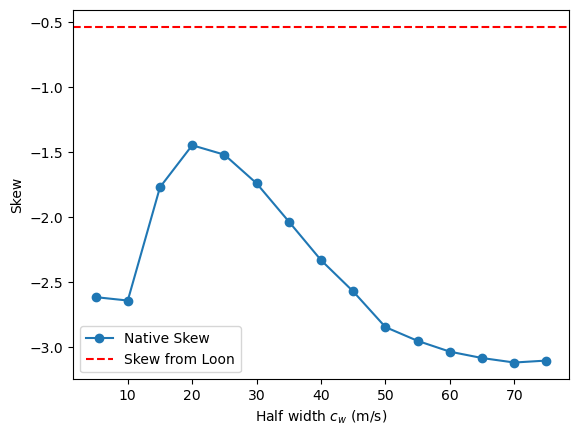

In [75]:
plt.plot(cws,log_skews,marker='o',label='Native Skew')
plt.axhline(log_skew_loon,linestyle='--',color='r',label='Skew from Loon')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Skew")

Text(0.5, 1.0, 'Log10 (mPa GW stress) - with source intermittency')

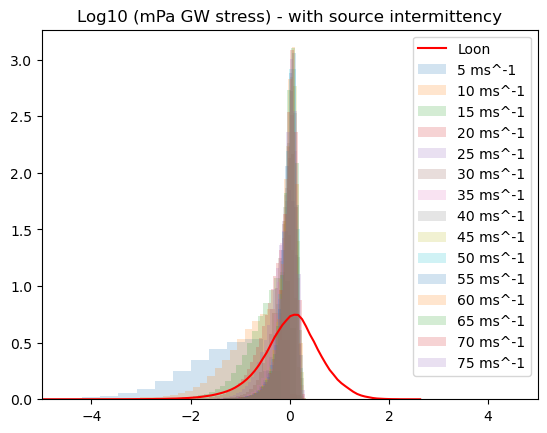

In [76]:
log_loon = np.log10(loon_u_abs)
loon_bin_heights,loon_bin_edges = np.histogram(log_loon[~np.isnan(log_loon)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
for i,c in enumerate(cws):
    uw_total = uw_ptvs[i]
    uw_total_abs = np.abs(uw_total[...,i_level])
    uw_total_abs = 1000*uw_total_abs[uw_total_abs > 0]
    plt.hist(np.log10(uw_total_abs),bins=100,alpha=0.2,label=f"{c} ms^-1",density=True)
    plt.legend()
plt.xlim(-5,5)
plt.title("Log10 (mPa GW stress) - with source intermittency")

## Adjust mode

In [77]:
def adjust_log_mode(samples): 
    log_samples = np.log10(samples)
    log_samples = log_samples[~np.isnan(log_samples)]
    weights,edges = np.histogram(log_samples,bins=100)
    bin_centers = 0.5*(edges[1:] + edges[:-1])
    max_bin = np.argmax(weights)
    mode_bin = bin_centers[max_bin]
    intermittency_factor = 10**(-mode_bin)
    return samples*10**(-mode_bin),intermittency_factor
                

5.278996
2.3943708
1.4175982
1.1574013
0.99645495
0.86876225
0.899746
0.9172726
0.93506724
0.80532163
0.8272438
0.8462791
0.8656611
0.8982373
0.9263181


Text(0, 0.5, 'Skew')

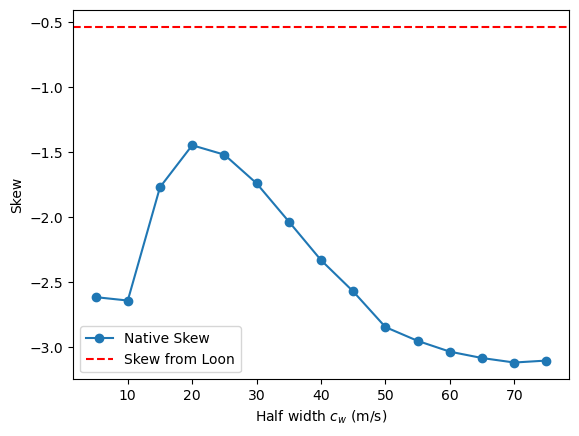

In [78]:
log_vars_recenter = []
log_skews_recenter = []

for i,c in enumerate(cws):
    uw_total = uw_ptvs[i]
    uw_total_abs = np.abs(uw_total[...,i_level])
    uw_total_abs = 1000*uw_total_abs[uw_total_abs > 0]
    recenter,eps_adjust = adjust_log_mode(uw_total_abs)
    print(eps_adjust)
    log_var,log_skew = variance_and_skew(np.log10(recenter))

    log_vars_recenter.append(log_var)
    log_skews_recenter.append(log_skew)

plt.plot(cws,log_skews_recenter,marker='o',label='Native Skew')
plt.axhline(log_skew_loon,linestyle='--',color='r',label='Skew from Loon')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Skew")

Text(0.5, 1.0, 'Log10 (mPa GW stress) - Recentered')

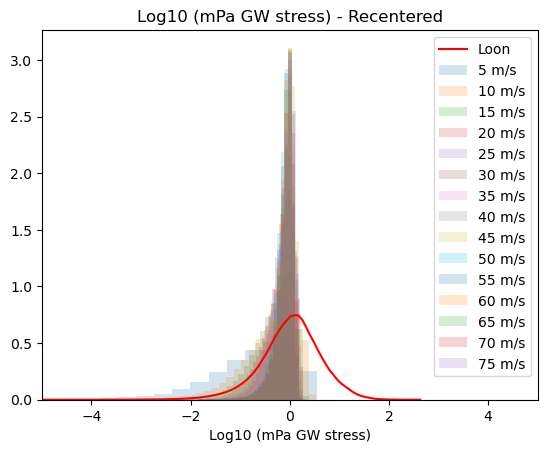

In [79]:
log_loon = np.log10(loon_u_abs)
loon_bin_heights,loon_bin_edges = np.histogram(log_loon[~np.isnan(log_loon)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
for i,c in enumerate(cws):
    uw_total = uw_ptvs[i]
    uw_total_abs = np.abs(uw_total[...,i_level])
    uw_total_abs = 1000*uw_total_abs[uw_total_abs > 0]
    recenter,_ = adjust_log_mode(uw_total_abs)
    plt.hist(np.log10(recenter),bins=100,alpha=0.2,label=f"{c} m/s",density=True)
    plt.legend()
plt.xlim(-5,5)
plt.xlabel('Log10 (mPa GW stress)')
plt.title("Log10 (mPa GW stress) - Recentered")